In [336]:
import numpy as np
import random
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import assemble, transpile
from qiskit.quantum_info import Statevector, Operator
import qiskit.quantum_info as qi
from qiskit.circuit.library import PauliFeatureMap, ZZFeatureMap
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer

# import basic plot tools
from qiskit.visualization import plot_histogram

In [337]:
N = 10
data = np.array([random.uniform(0, 2*np.pi) for _ in range(N)])
# Calculate the histogram
hist, bin_edges = np.histogram(data, bins='auto')
distr = hist / N
hist, distr

(array([3, 0, 3, 1, 3]), array([0.3, 0. , 0.3, 0.1, 0.3]))

In [338]:
from scipy.stats import entropy

# Example probability distributions (replace these with your data)
# P and Q should be lists, arrays, or any iterable representing the PMFs or PDFs.
P = [1, 6, 8]
Q = [0, 0.6, 0.3] # Problem!!!

# Compute the KL divergence
kl_divergence = entropy(P, Q)
print("KL divergence:", kl_divergence)

KL divergence: inf


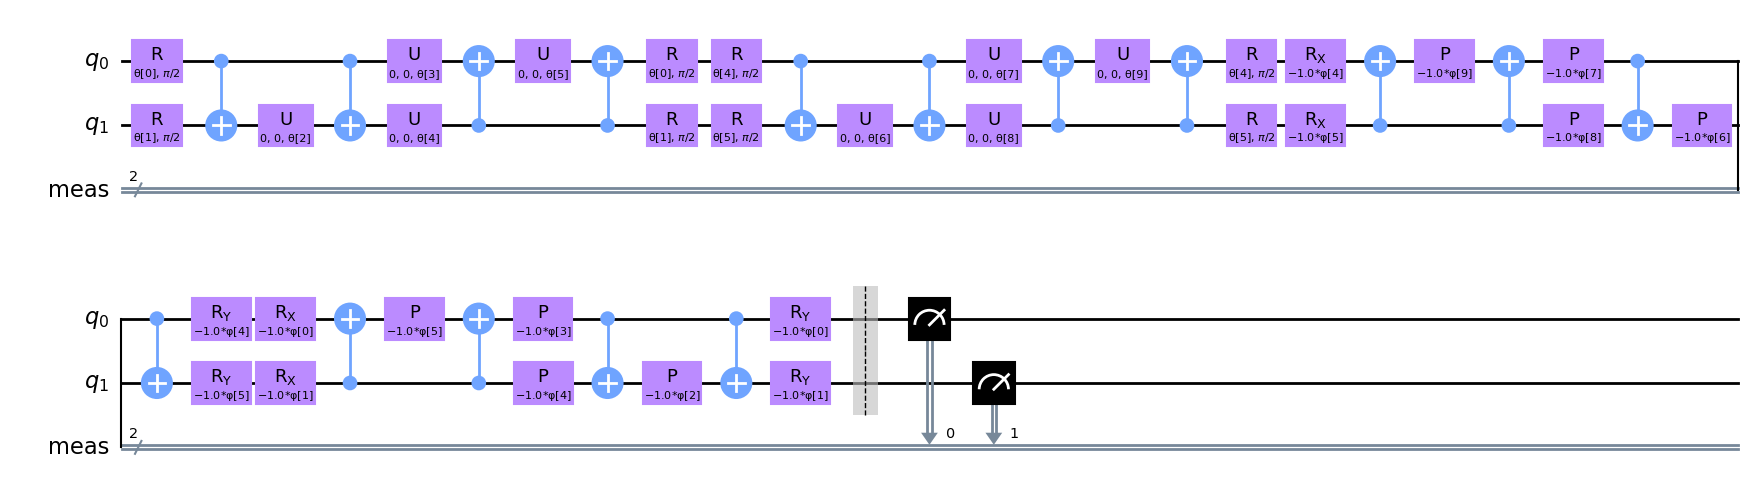

In [339]:
M = 2
layer_par_n = 4
layers_n = 2

theta_list = ParameterVector('θ', length = layer_par_n*layers_n+2)
phi_list = ParameterVector('φ', length = layer_par_n*layers_n+2)


def make_circuit(layers_n):
    
    circuit_theta = QuantumCircuit(M)
    circuit_phi = QuantumCircuit(M)
    

    for layer in range(layers_n):
        circuit_theta.ry(theta_list[layer*layer_par_n],0)
        circuit_theta.ry(theta_list[layer*layer_par_n+1],1)

        circuit_theta.cx(0,1) 
        circuit_theta.p(theta_list[layer*layer_par_n+2],1) 
        circuit_theta.cx(0,1)  

        circuit_theta.p(theta_list[layer*layer_par_n + 3],0) 
        circuit_theta.p(theta_list[layer*layer_par_n + 4],1)

        circuit_theta.cx(1,0) 
        circuit_theta.p(theta_list[layer*layer_par_n + 5],0) 
        circuit_theta.cx(1,0) 

        circuit_theta.ry(theta_list[layer*layer_par_n],0)
        circuit_theta.ry(theta_list[layer*layer_par_n+1],1)
    
    for layer in range(layers_n):
    
        circuit_phi.ry(phi_list[layer*layer_par_n],0)
        circuit_phi.ry(phi_list[layer*layer_par_n+1],1)

        circuit_phi.cx(0,1) 
        circuit_phi.p(phi_list[layer*layer_par_n+2],1) 
        circuit_phi.cx(0,1)  

        circuit_phi.p(phi_list[layer*layer_par_n + 3],0) 
        circuit_phi.p(phi_list[layer*layer_par_n + 4],1)

        circuit_phi.cx(1,0) 
        circuit_phi.p(phi_list[layer*layer_par_n + 5],0) 
        circuit_phi.cx(1,0) 

        circuit_phi.rx(phi_list[layer*layer_par_n],0)
        circuit_phi.rx(phi_list[layer*layer_par_n+1],1)

    circuit_theta.append(circuit_phi.inverse(), circuit_theta.qubits[:2])
        
    # for k in range(M):
    #     circuit.rx(data_list[k],k)

    return  circuit_theta

circ = make_circuit(layers_n)
circ.measure_all()
circ.decompose().draw("mpl")

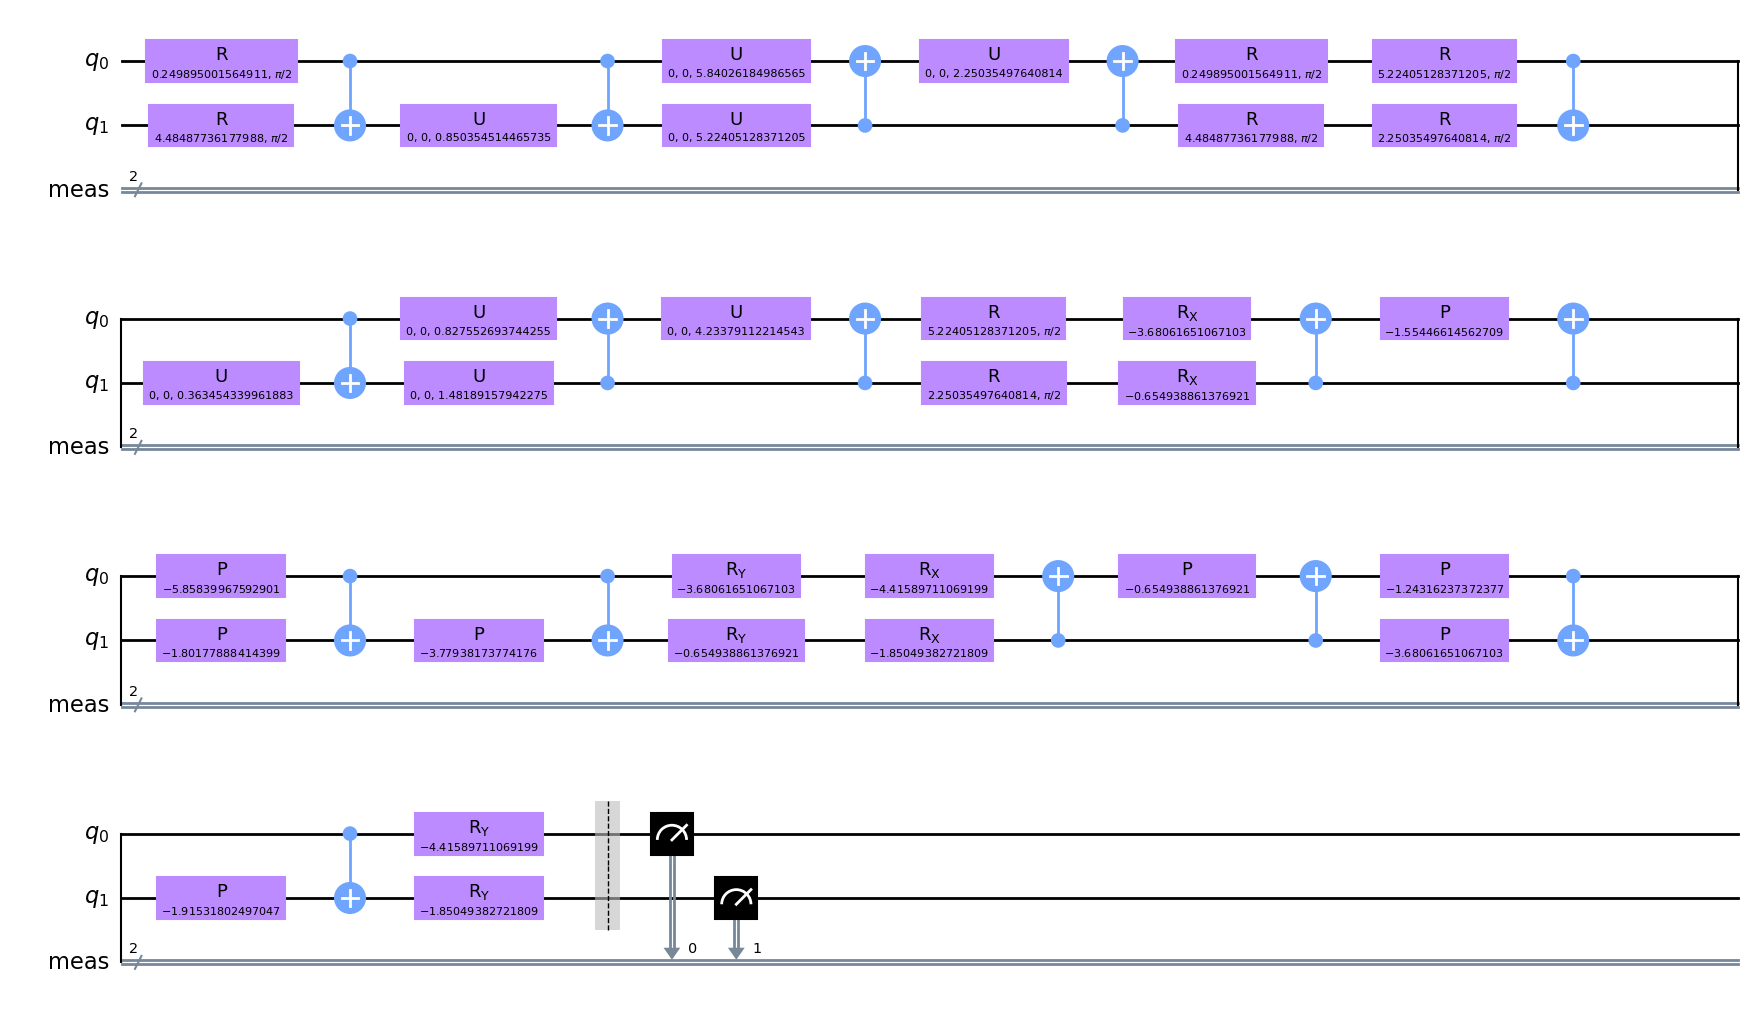

In [340]:
par1 = [random.uniform(0, 2*np.pi) for _ in range(layer_par_n*layers_n + 2)]
par2 = [random.uniform(0, 2*np.pi) for _ in range(layer_par_n*layers_n + 2)]
circ_par = circ.assign_parameters({theta_list: par1,phi_list: par2})
circ_par.decompose().draw("mpl")

In [341]:
shots = 2048
# Let's see the results!
def get_results(circ):
  aer_sim = Aer.get_backend('aer_simulator')
  t_circ = transpile(circ, aer_sim)
  qobj = assemble(t_circ, shots=shots)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()

  return answer

def fid(circuit):
  counts = get_results(circuit)
  if "00" not in counts.keys():
    answer = 0
  else: answer = counts['00']/shots 
  return answer 

def gen_angles():
  angles1 = np.array([random.uniform(0, 2*np.pi) for _ in range(layer_par_n*layers_n + 2)])
  angles2 = np.array([random.uniform(0, 2*np.pi) for _ in range(layer_par_n*layers_n + 2)])
  return angles1, angles2

def fid_sampling(circuit, N_samples):
  fids = []
  for i in range(N_samples):
    angles = gen_angles()
    circ = circuit.assign_parameters({theta_list: angles[0], phi_list: angles[1]})
    fids.append(fid(circ))
  return fids

N_samples = 2000
all_fidelities = fid_sampling(circ, N_samples)

In [342]:
all_fidelities[:5]

[0.30615234375, 0.0009765625, 0.02197265625, 0.19482421875, 0.04541015625]

In [343]:
n_bins = 75

def prob_haar(F):
    optimal_level = N_samples*3*(1-F)**2 / n_bins
    return optimal_level

fid_values = np.linspace(0,1,n_bins)
probs_haar = [prob_haar(F) for F in fid_values]
addition = [probs_haar[len(probs_haar)-5] for i in range(5)]
probs_haar = probs_haar[:len(probs_haar)-5] + addition 
probs_haar[len(probs_haar)-15:]

[2.863403944485024,
 2.468955441928414,
 2.1037253469685875,
 1.7677136596055496,
 1.4609203798392978,
 1.1833455076698316,
 0.9349890430971514,
 0.7158509861212552,
 0.5259313367421469,
 0.36523009495982445,
 0.23374726077428684,
 0.23374726077428684,
 0.23374726077428684,
 0.23374726077428684,
 0.23374726077428684]

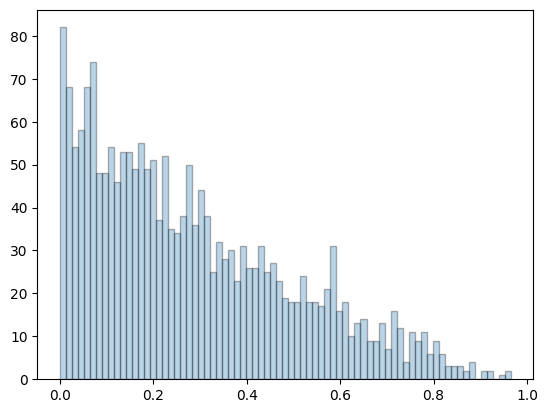

In [344]:
fid_hist = plt.hist(all_fidelities, bins=n_bins,  edgecolor='black', alpha=0.3)

In [345]:
kl_divergence = entropy(fid_hist[0], probs_haar)
kl_divergence

0.05144104178407653

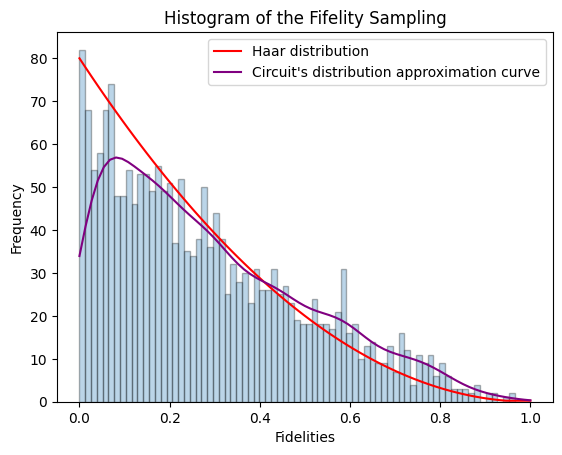

In [352]:
from scipy.stats import gaussian_kde
plt.hist(all_fidelities, bins=n_bins,  edgecolor='black', alpha=0.3)
plt.title('Histogram of the Fifelity Sampling')
plt.xlabel('Fidelities')
plt.ylabel('Frequency')
plt.plot(fid_values, probs_haar, color='red', label='Haar distribution')
# plt.axhline(0.5, color='red', linestyle='dashed', linewidth=2, label='Line at x={}'.format(0.5))


# Calculate the approximation
kde = gaussian_kde(all_fidelities)
y_values = N_samples* kde(fid_values) /n_bins

# Draw the approximation curve on top of the histogram
plt.plot(fid_values, y_values, color='purple', label="Circuit's distribution approximation curve")

plt.legend()
plt.show()

## Entanglement Capability

In [347]:
layers_n = 7
layer_par_n = 4
theta_list = ParameterVector('θ', length = layer_par_n*layers_n)

def make_circuit_ec(layers_n):

    circuit_theta = QuantumCircuit(M)

    for layer in range(layers_n):
        # circuit_theta.rx(theta_list[0],0)
        # circuit_theta.rx(theta_list[1],1)

        # circuit_theta.cx(0,1) 
        # circuit_theta.p(theta_list[layer*layer_par_n + 2],1) 
        # circuit_theta.cx(0,1)  

        # circuit_theta.p(theta_list[layer*layer_par_n  + 3],0) 
        # circuit_theta.p(theta_list[layer*layer_par_n + 4],1)

        # circuit_theta.cx(1,0) 
        # circuit_theta.p(theta_list[layer*layer_par_n + 5],0) 
        # circuit_theta.cx(1,0) 

        circuit_theta.h([0,1])

        circuit_theta.cx(0,1) 
        circuit_theta.p(theta_list[layer*layer_par_n],1) 
        circuit_theta.cx(0,1)  

        circuit_theta.p(theta_list[layer*layer_par_n  + 1],0) 
        circuit_theta.p(theta_list[layer*layer_par_n + 2],1)

        circuit_theta.cx(1,0) 
        circuit_theta.p(theta_list[layer*layer_par_n + 3],0) 
        circuit_theta.cx(1,0) 
    circuit_theta.h([0,1])
    
    # circuit_theta.rx(theta_list[0],0)
    # circuit_theta.rx(theta_list[1],1)

    return  circuit_theta

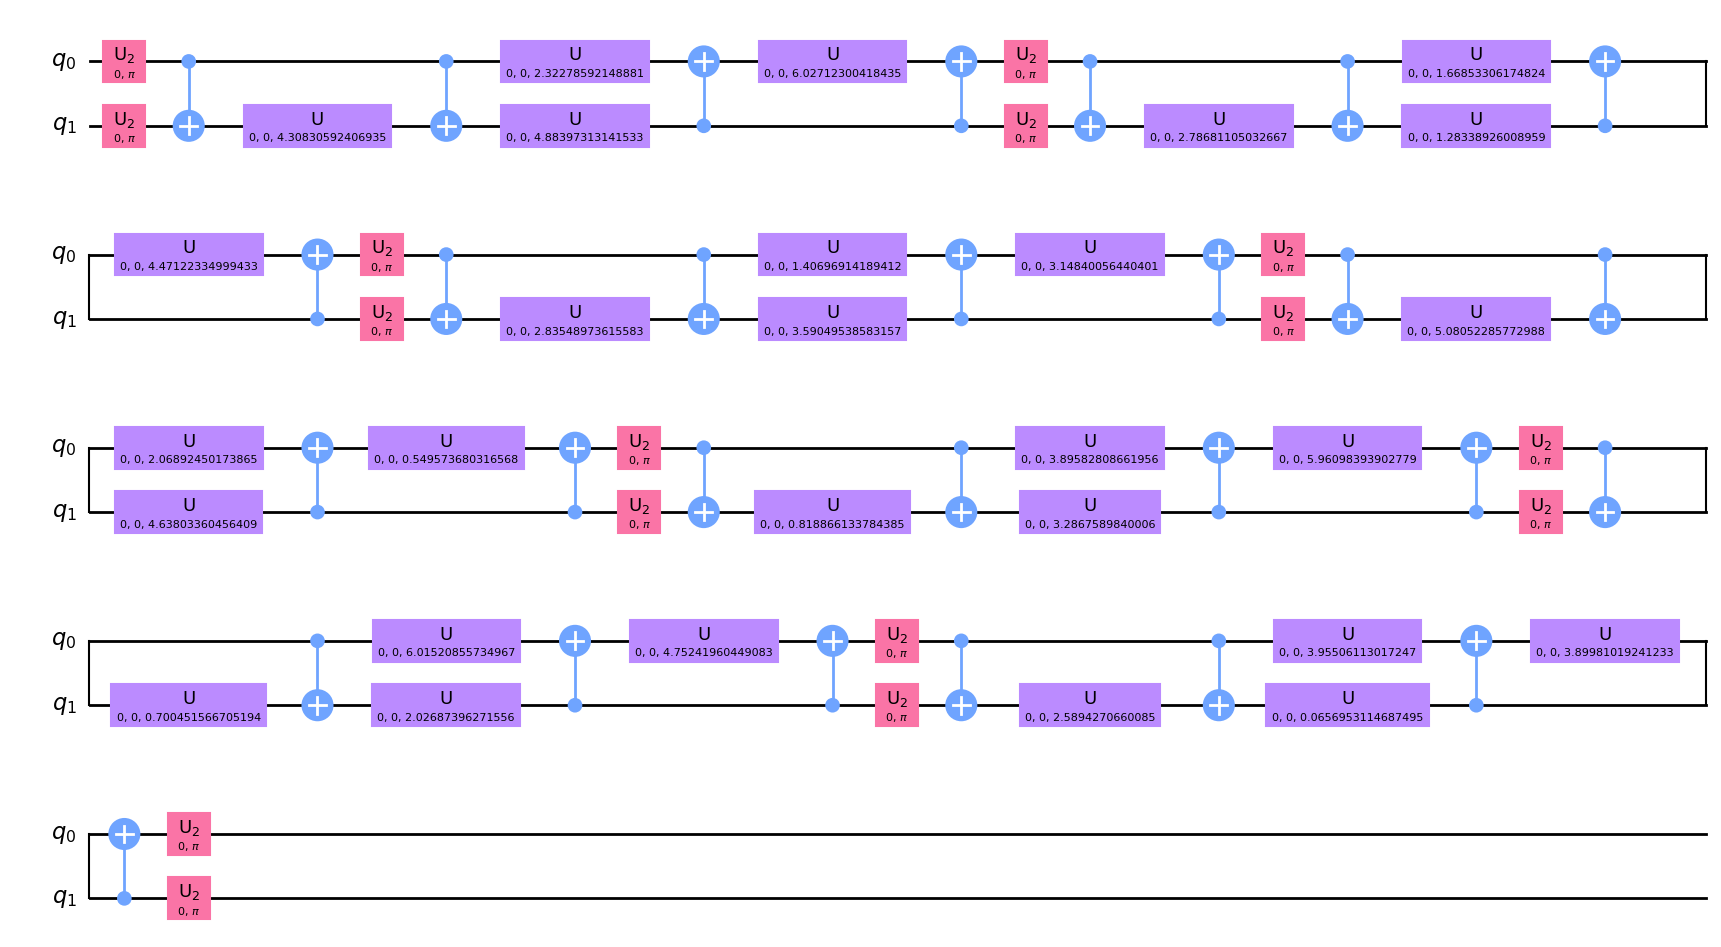

In [348]:
my_circ = make_circuit_ec(layers_n)
par1 = [random.uniform(0, 2*np.pi) for _ in range(layer_par_n*layers_n)]
my_circ_par = my_circ.assign_parameters({theta_list: par1})
my_circ_par.decompose().draw("mpl")

In [349]:
sv = Statevector(my_circ_par)
sv.draw(output='latex')

<IPython.core.display.Latex object>

In [350]:
from qiskit.quantum_info import DensityMatrix, partial_trace

rho = DensityMatrix(my_circ_par)
rho_a = partial_trace(state=rho, qargs=[1])
purity = np.trace(np.matmul(rho_a.data,rho_a.data))
print(purity)
rho_a.draw(output='latex')

(0.7931318261198795-3.0531133177191805e-16j)


<IPython.core.display.Latex object>

In [351]:
def entropy(circuit):
    rho = DensityMatrix(circuit)
    rho_1 = partial_trace(state=rho, qargs=[1])
    purity_1 = np.trace(np.matmul(rho_1.data,rho_1.data))
    rho_0 = partial_trace(state=rho, qargs=[0])
    purity_0 = np.trace(np.matmul(rho_0.data,rho_0.data))
    answer = 1 - 0.5*(purity_0 + purity_1)
    return answer
    
def entr_sampling(circuit):
  entrs = []
  for _ in range(N, N_samples):
    angles = np.array([random.uniform(0, 2*np.pi) for _ in range(layer_par_n*layers_n)])
    circ = circuit.assign_parameters({theta_list: angles})
    entrs.append(entropy(circ))
  return entrs

entrs = entr_sampling(my_circ)
average_entropy = sum(entrs) / N_samples
np.round(average_entropy,4)

(0.201-0j)